### Generate training data: channels and approximate channel inverses 
### Generate test data: channels and approximate channel inverses

In [62]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=1000 # 1000000
num_test=10

# assume we know the channel_length
channel_length = 2
num_preambles = 10
preamble_length = 10

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

# channel_train: assume we are working with just real parts, list of all used channels
# preamble_train: use same channel on num_preambles different preambles and store them to train with
# inverse_train: contains channel_inverse per preamble, inverse is composed of [1/a0, -a1/a0, ...... -an/a0]
channel_train = np.zeros((num_train,channel_length))
preamble_train = np.zeros((num_train*num_preambles, preamble_length))
inverse_train = np.zeros((num_train*num_preambles,channel_length))


channel_test = np.zeros((num_train,channel_length))
preamble_test = np.zeros((num_train*num_preambles, preamble_length))
inverse_test = np.zeros((num_train*num_preambles,channel_length))

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
        
    for k in range(num_preambles):
        preamble_train[i+k,:] = sig.convolve(preambles[k], channel_train[i], mode='same')
        inverse_train[i+k,0] = 1/channel_train[i,0]
        for j in range(1, channel_length):
            inverse_train[i+k,j] = -channel_train[i,j]/channel_train[i,0]

        
        
for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
        
    for k in range(num_preambles):
        preamble_test[i+k,:] = sig.convolve(preambles[k], channel_test[i], mode='same')
        inverse_test[i+k,0] = 1/channel_test[i,0]
        for j in range(1, channel_length):
            inverse_test[i+k,j] = -channel_test[i,j]/channel_test[i,0]

Epoch 0, Cost 0.19186481833457947, MC Cost: 0.005473173689097166
Epoch 100, Cost 0.020923946052789688, MC Cost: 0.0008548892801627517
Epoch 200, Cost 0.011456516571342945, MC Cost: 0.0007086237310431898
Epoch 300, Cost 0.022645557299256325, MC Cost: 0.0009990964317694306
Epoch 400, Cost 0.019382866099476814, MC Cost: 0.0010039209155365825
Epoch 500, Cost 0.009550025686621666, MC Cost: 0.0010812105610966682
Epoch 600, Cost 0.006211585830897093, MC Cost: 0.0010736543918028474
Epoch 700, Cost 0.015087827108800411, MC Cost: 0.0011320747435092926
Epoch 800, Cost 0.012006004340946674, MC Cost: 0.0011656692950055003
Epoch 900, Cost 0.001837265444919467, MC Cost: 0.0011306690284982324
Epoch 1000, Cost 0.0025865298230201006, MC Cost: 0.0011016279458999634
Epoch 1100, Cost 0.0020973174832761288, MC Cost: 0.0011620091972872615
Epoch 1200, Cost 0.0006591113051399589, MC Cost: 0.0011808364652097225
Epoch 1300, Cost 0.0018501713639125228, MC Cost: 0.0011766751995310187
Epoch 1400, Cost 0.00066520838

"\n\n# start the session\nwith tf.Session() as sess:\n    #    initialize the variables\n    sess.run(init)\n    mc_losses = []\n        \n    for epoch in range(epochs):\n        \n        preamble_batch = preambles[0]\n        real_inv_batch = [1,0]\n        for rand in range(0,batch_size-1):\n            rand_int = np.random.randint(0,num_train)\n            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))\n            real_inv_batch = np.vstack((real_inv_batch, inverse_train[rand_int]))\n            \n        preamble_batch = preamble_batch.reshape((batch_size, preamble_length))\n        real_inv_batch = real_inv_batch.reshape((batch_size, channel_length))\n        print(preamble_batch)\n        print(real_inv_batch)\n        \n        _,cost,inverse_channel2 = sess.run([optimizer, cost, inverse_channel], \n                                          feed_dict={recieved_preamble: preamble_batch, real_inverse: real_inv_batch,\n                         adaptive_le

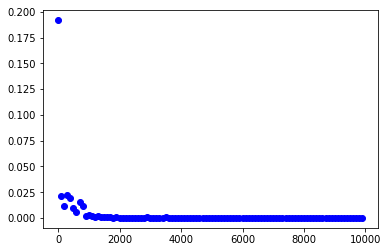

In [67]:
# fix a random seed to have the same results
np.random.seed()

learning_rate = 0.001
epochs = 10000#10000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10

# placeholders for input and output
adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
recieved_preamble = tf.placeholder(tf.float32, [None, preamble_length])
real_inverse = tf.placeholder(tf.float32, [None, channel_length])

layer1 = tf.contrib.layers.fully_connected(recieved_preamble, num_outputs=150, activation_fn=tf.nn.tanh)
layer2 = tf.contrib.layers.fully_connected(layer1, num_outputs=150, activation_fn=tf.nn.tanh)
layer3 = tf.contrib.layers.fully_connected(layer2, num_outputs=channel_length, activation_fn=tf.identity)

inverse_channel = layer3

cost_fn = tf.reduce_mean(tf.reduce_mean((real_inverse-inverse_channel)**2, axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(cost_fn)

init = tf.global_variables_initializer()
plt.figure()


with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        # for each batch start the batch with passing the first preamble through the identity channel
        identity_channel = np.zeros(channel_length)
        identity_channel[0] = 1
        preamble_batch = sig.convolve(preambles[0], identity_channel, mode='same')
        real_inv_batch = identity_channel
        
        for rand in range(0,batch_size-1):
            rand_int = np.random.randint(0,num_train*num_preambles)
            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))
            real_inv_batch = np.vstack((real_inv_batch, inverse_train[rand_int]))
            
        preamble_batch.reshape((batch_size, preamble_length))
        real_inv_batch.reshape((batch_size, channel_length))
        
        _,cost,inverse_channel2 = sess.run(
            [optimizer, cost_fn, inverse_channel], 
            feed_dict={recieved_preamble: preamble_batch, 
                       real_inverse: real_inv_batch,adaptive_learning_rate: learning_rate * (decay**epoch)})
        if epoch % 100 == 0: 
            plt.plot(epoch, cost, 'bo')
            mc_cost, mc_inversion = sess.run(
                [cost_fn, inverse_channel], feed_dict={recieved_preamble: preamble_test, real_inverse: inverse_test})
            print('Epoch {}, Cost {}, MC Cost: {}'.format(epoch, cost, mc_cost))